In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [8]:
# мин-макс нормализация всего кроме таргета
target = df['Цена']
df.drop(columns = 'Цена', inplace = True)
df = (df-df.min ())/(df.max ()-df.min ())
df['Цена'] = target

In [ ]:
df_raw = pd.read_csv('df-3.csv')

Text(0.5, 0, 'Цена')

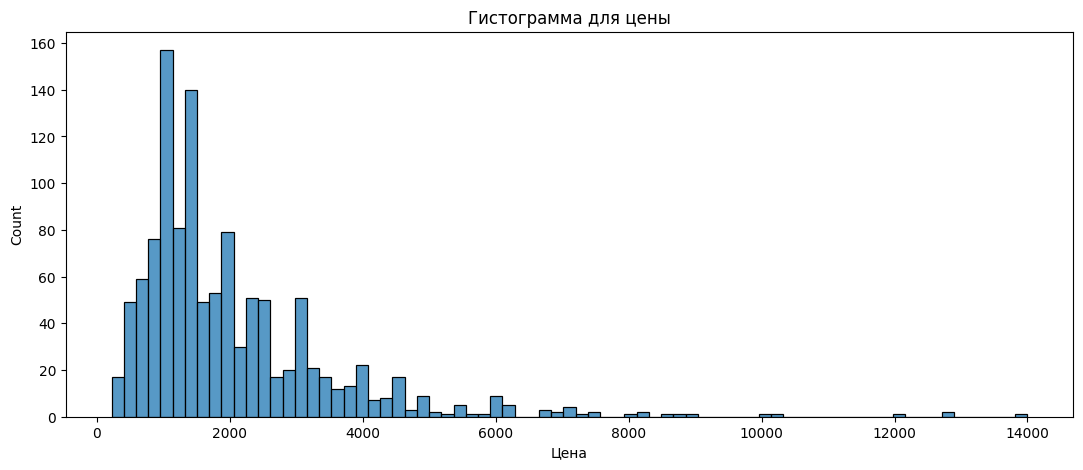

In [10]:
plt.figure(figsize=(13,5))
sns.histplot(x='Цена',data = df_raw, bins=75)
plt.title('Гистограмма для цены')
plt.xlabel('Цена')

Распределние ни на что пока не похоже, так как относительно нормального имеет сильное смещение влево. Проверим, может быть, распределение - лог-нормальное?

Text(0.5, 0, 'Логарифм Цены')

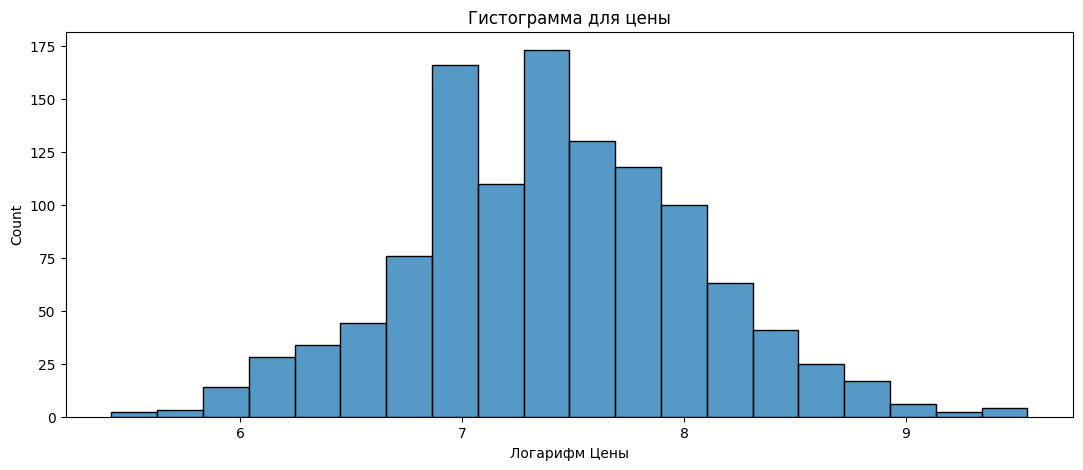

In [19]:
from math import log
plt.figure(figsize=(13,5))
sns.histplot(df_raw['Цена'].apply(lambda x: np.log(x+1)), bins = 20)
plt.title('Гистограмма для цены')
plt.xlabel('Логарифм Цены')

Как мы видим, распределение стало похоже на нормальное! Вызывает сомнение столбец, который соответствует log(Цена) ~ 6.9. НО это объяснимо тем, что $e^{6.91} = 1000$, а таких значений много из-за желания репетиторов поставить "круглую цену".

Далее изучим распределение оценок:

In [28]:
df_raw_filter = df_raw[df_raw['Оценка'] != 1]

<Axes: xlabel='Оценка', ylabel='Count'>

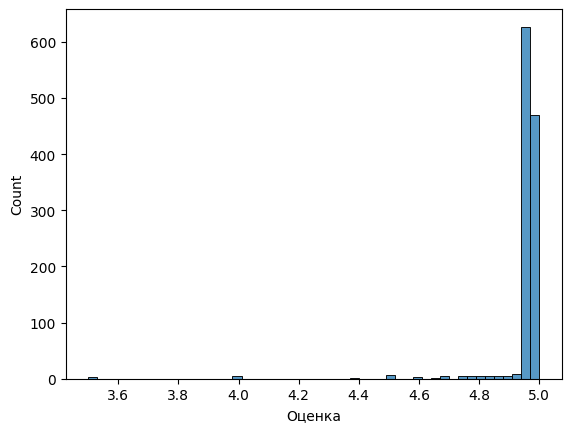

In [29]:
sns.histplot(x='Оценка',data = df_raw_filter, bins=50) # рассмотрим значения оценок без выброса

In [30]:
round(df_raw_filter['Оценка'].mean(), 2)

4.96

Видно, что значения оценки ниже, чем 4.9 являются крайне редкими, а средняя оценка 4.96. Возможно, распределение 5-'Оценка' является пуассоновским (поскольку распределение Пуассона предсказывает вероятность редких событий) с матожиданием 0.04.

Для наглядности схожести с распределением Пуассона построим график 5-'Оценка'.

<ipython-input-77-a4cea912821a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw_filter['5 - Оценка'] = 5 - df_raw_filter['Оценка']


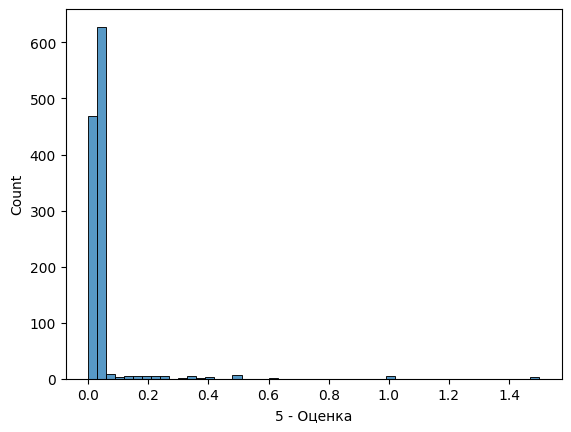

In [77]:
df_raw_filter['5 - Оценка'] = 5 - df_raw_filter['Оценка']
sns.histplot(x = '5 - Оценка', data = df_raw_filter, bins=50);

Также несложно предположить, что предмет, который преподаёт репетитор, значительно влияет на стоимость часа. Давайте подробнее изучим эту зависимость.

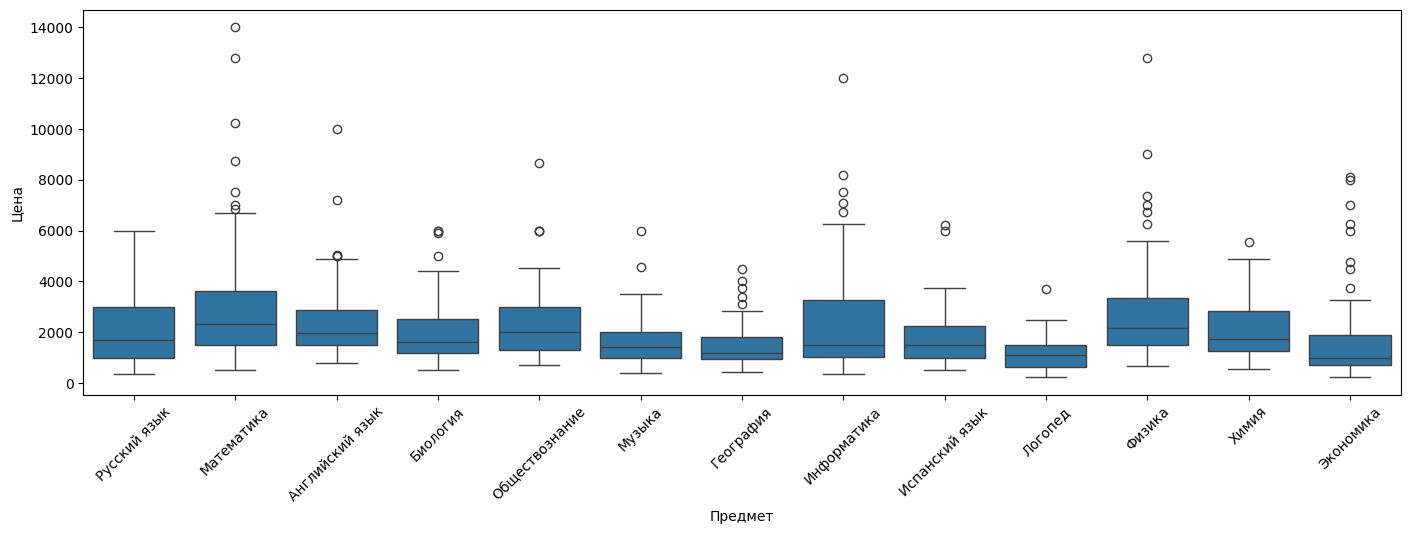

In [64]:
object_list = {'Русский язык': 'russkij-yazyk',
               'Математика': 'matematika-elementarnaya',
               'Английский язык': 'anglijskij-yazyk',
               'Биология': 'biologiya',
               'Обществознание': 'obshchestvoznanie',
               'Музыка': 'muzyka',
               'География': 'geografiya',
               'Информатика': 'informatika',
               'Испанский язык': 'ispanskij-yazyk',
               'Логопед' : 'logopedy',
               'Физика' : 'fizika',
               'Химия' : 'himiya',
               'Биология' : 'biologiya',
               'Экономика' : 'ekonomika'
               } # это список всех предметов, которые мы рассматриваем

subject_prices = df_raw.groupby('Предмет')['Цена'].mean()

plt.figure(figsize=(17,5))
sns.boxplot(x='Предмет',y='Цена',data = df_raw);
plt.xticks(rotation=45);

In [65]:
round(subject_prices.loc['Математика'] / subject_prices.loc['Русский язык'], 2) # отношение средних цен преподавателей по математике и русскому

1.45

Удивительно, но разница между двумя основными предметами ЕГЭ (русским и математикой) составляет целых 45%. Возможно, это обусловлено большим количеством выбросов среди репетиторов по математике. Среди преподавателей русского, как мы видим, выбросов нет вообще.

Но, в любом случае, на данных наблюдается зависимость, что цены на репетиторов по математике выше, чем на коллег по русскому. Выдвинем гипотезу, что матожидание цен на математиков выше на 30%.

Гипотезы:


*   Распределение цены имеет лог-нормальное распределение
*   Распределение оценок имеет распределение пуассона с lambda = 0.04 (в дальнейшем перейдём к целым значениям, как того требует распределение Пуассона)
*   Стоимость занятий с репетитором по математике в среднем на 30% выше, чем с преподавателем по русскому языку



Рассмотрим первую гипотезу: для этого с помощью теста Шапиро-Уилка рассчитаем p-value. Мы готовы смириться с тем, что отвергнем верную гипотезу с вероятностью 5%.

In [66]:
from scipy import stats

# Выполняем тест Шапиро-Уилка
stat, p = stats.shapiro(df_raw['Цена'].apply(lambda x: np.log(x+1)))

# Выводим результаты теста
print('Статистика теста =', stat, ', p-значение =', p)

# Проверяем нулевую гипотезу
alpha = 0.05
if p > alpha:
    print('Данные похожи на нормальное распределение')
else:
    print('Данные не похожи на нормальное распределение')

Статистика теста = 0.9958792328834534 , p-значение = 0.0033832425251603127
Данные не похожи на нормальное распределение


P-value слишком мало. Отвергаем основную гиптоезу. Мы ошиблись с вероятностью менее 1% - достойно.

Рассмотрим вторую гипотезу: для этого с помощью критерия хи-квадрат сравним нашу выборку оценок (а точнее '5 - оценка' * 100, причём приведённые к целым значениям, так как распределение Пуассона предсказывает только целые значения переменной) с реальными значениями, которые предполагает распределение Пуассона с lambda = 4 (лямбду определили на основе среднего нашей выборки * 100). Мы, как и в прошлый раз, готовы смириться с ошибкой 5%.

Примечание: A - мизерная добавка к вероятности каждого значения k в случае. Она нужна для того, чтобы суммы expected_freq и observed_freq совпали (базово они не совпадают, так как вероятности в пуассоне - не целые числа, а количество учителей с определённой оценкой - целое число), в противном случае критерий хи-квадрат был бы нереалищуем.

In [103]:
from scipy.stats import poisson, chisquare

A = 1155 - sum([len(df_raw_filter['5 - Оценка']) * poisson.pmf(k, 4) for k in range(15)]) # та самая добавка

In [104]:
# Вычисляем частоту встречаемости значений
observed_freq, _ = np.histogram(df_raw_filter['5 - Оценка'].apply(lambda x: int(round(x, 2) * 100)), bins=15)

# Ожидаемая частота для распределения Пуассона
expected_freq = np.array([len(df_raw_filter['5 - Оценка']) * poisson.pmf(k, 4) + A/15 for k in range(15)])

# Выполняем тест хи-квадрат
statistic, p_value = chisquare(observed_freq, expected_freq)

# Выводим результаты теста
print('Статистика теста =', statistic, ', p-значение =', p_value)

# Проверяем нулевую гипотезу
alpha = 0.05
if p_value > alpha:
    print('Распределение похоже на распределение Пуассона')
else:
    print('Распределение не похоже на распределение Пуассона')

Статистика теста = 56806.87909160231 , p-значение = 0.0
Распределение не похоже на распределение Пуассона


К сожалению, вероятность того, что это распределение было Пуассоновским меньше, чем то, что вас завтра задавит  метеорит, - она равна 0%.

Перейдём к 3 гипотезе об отличии матожиданий цен на преподавателей по русскому и по математике: для этого домножим значения всех цен на репетиторов по русскому на 1.3, после чего с помощью t-теста проверим получившиеся выборки на равенство мат.ожиданий на уровне значимости 5%.

In [105]:
# Выполняем t-тест для независимых выборок
t_stat, p_value = stats.ttest_ind(df_raw[df_raw['Предмет'] == 'Математика']['Цена'], df_raw[df_raw['Предмет'] == 'Русский язык']['Цена'] * 1.3)

# Выводим результаты теста и проверяем гипотезу
print('t-статистика =', t_stat)
print('p-значение =', p_value)
if p_value < 0.05:
    print('Отвергаем нулевую гипотезу. Средние значения выборок различны.')
else:
    print('Не удалось отвергнуть нулевую гипотезу. Нет оснований считать, что средние значения выборок различны.')

t-статистика = 0.9915085102497935
p-значение = 0.32278324937798986
Не удалось отвергнуть нулевую гипотезу. Нет оснований считать, что средние значения выборок различны.


Ура! Мы не отвергаем гипотезу и принимаем, что мат. ожидание отличается на 30%.

Для дальнейшей работы с моделью проведём стандартизацию данных.
Приведём все признаки к единообразным значениям. Так как one-hot закодированные категориальные признаки принимают значения от 0 до 1, применим мин-макс нормализацию и к численным признакам. Благодаря единообразию значений признаков, коэффициенты будут хорошо интерпретируемы.

In [ ]:
# мин-макс нормализация всего кроме таргета
target = df_raw['Цена']
df_raw.drop(columns = 'Цена', inplace = True)
df = (df_raw-df_raw.min ())/(df_raw.max ()-df_raw.min ())
df['Цена'] = target